In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score


In [130]:
df = pd.read_csv('AIS_2024_01_01.csv',usecols=['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'VesselType'], parse_dates=['BaseDateTime'])

In [131]:
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselType
0,338075892,2024-01-01 00:00:03,43.65322,-70.25298,0.0,358.8,90.0
1,367669550,2024-01-01 00:00:04,46.20031,-123.38573,0.0,281.9,30.0
2,367118980,2024-01-01 00:00:06,29.98534,-90.40674,0.0,30.1,31.0
3,367177840,2024-01-01 00:00:05,39.88654,-75.17649,0.0,304.4,52.0
4,367305420,2024-01-01 00:00:06,18.33273,-64.95229,0.0,332.6,52.0
...,...,...,...,...,...,...,...
7296270,564519000,2024-01-01 23:46:07,13.80869,144.58286,13.3,0.6,70.0
7296271,564519000,2024-01-01 23:47:16,13.81304,144.58292,13.4,0.7,70.0
7296272,564519000,2024-01-01 23:48:27,13.81743,144.58299,13.5,0.9,70.0
7296273,564519000,2024-01-01 23:53:06,13.83440,144.58546,12.9,21.5,70.0


In the above dataframe, MMSI stands for Maritime Mobile Service Identity, which is a unique 9-digit number used to identify a ship. This is crucial for distinguishing different vessels in data. 
BaseDateTime is the timestamp of the AIS(Automatic Identification System) Signal, which is vital for understanding the sequence of vessel movements and for any time-series analysis or temporal patterns in vessel activity.
LAT,LON (Latitude and Longitude) are the geographical coordinates of each AIS signal. These are essential for any spatial analysis, including tracking vessel routes or proximity to specific areas like ports.
SOG stands for Speed Over Ground and it is the speed at which the vessel is moving over the bottom surface. This is a critical parameter for predicting vessel movement times and for identifying unusual patterns like speeding.
COG (Course Over Ground) is the direction in which a vessel is moving, which, combined with SOG, helps in predicting the vessel's future location.
VesselType indicates the type of vessel, which can affect its speed and allowable areas of operation. Different vessel types have different operational behaviors and constraints.

In [132]:
# Filter out stationary vessels
df = df[df['SOG'] > 0.1]

In [133]:
df.isnull().sum()

MMSI               0
BaseDateTime       0
LAT                0
LON                0
SOG                0
COG                0
VesselType      1711
dtype: int64

In [134]:
df[df['VesselType'].isnull()]

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselType
8869,443987689,2024-01-01 00:01:14,35.83970,-75.61885,0.2,0.0,NaN
8895,338489834,2024-01-01 00:01:16,47.64250,-122.34344,1.3,195.6,NaN
18374,443987689,2024-01-01 00:03:15,35.83970,-75.61894,2.0,249.8,NaN
20836,338489834,2024-01-01 00:03:36,47.64328,-122.34311,1.4,15.7,NaN
26402,443987689,2024-01-01 00:05:15,35.83957,-75.61882,2.0,133.5,NaN
...,...,...,...,...,...,...,...
7232954,338489834,2024-01-01 22:39:17,47.64331,-122.33619,1.4,277.9,NaN
7252266,338200101,2024-01-01 22:59:52,35.83970,-75.61888,0.6,0.0,NaN
7254712,338218167,2024-01-01 23:04:10,33.84916,-118.40056,0.2,359.3,NaN
7254724,338489834,2024-01-01 23:04:26,47.64348,-122.34124,0.8,271.4,NaN


In [135]:
missing_vessel_type = df['VesselType'].isnull().sum()
total_rows = df.shape[0]
percent_missing = (missing_vessel_type / total_rows) * 100
print(f"Missing 'VesselType' data: {percent_missing:.2f}%")

Missing 'VesselType' data: 0.09%


In [136]:
df = df[df['VesselType'].isnull() == False]

In [137]:
df.isna().sum()

MMSI            0
BaseDateTime    0
LAT             0
LON             0
SOG             0
COG             0
VesselType      0
dtype: int64

In [138]:
vessel_type_mapping = {
    0: "Not Available",
    1: "Reserved",
    2: "Reserved",
    3: "Reserved",
    4: "Reserved",
    5: "Reserved",
    6: "Reserved",
    7: "Reserved",
    8: "Reserved",
    9: "Reserved",
    10: "Reserved",
    20: "Wing In Ground",
    21: "Wing In Ground (Hazardous)",
    22: "Wing In Ground (Hazardous Category A)",
    23: "Wing In Ground (Hazardous Category B)",
    24: "Wing In Ground (Hazardous Category C)",
    25: "Wing In Ground (Hazardous Category D)",
    29: "Wing In Ground (No Additional Information)",
    30: "Fishing",
    31: "Towing",
    32: "Towing (Length exceeds 200m or breadth exceeds 25m)",
    33: "Dredging or Underwater Operations",
    34: "Diving Operations",
    35: "Military Operations",
    36: "Sailing",
    37: "Pleasure Craft",
    40: "High-Speed Craft (HSC)",
    41: "HSC (Hazardous Category A)",
    42: "HSC (Hazardous Category B)",
    43: "HSC (Hazardous Category C)",
    44: "HSC (Hazardous Category D)",
    49: "HSC (No Additional Information)",
    50: "Pilot Vessel",
    51: "Search and Rescue (SAR) Vessel",
    52: "Tug",
    53: "Port Tender",
    54: "Anti-Pollution Equipment",
    55: "Law Enforcement",
    56: "Spare - Local Vessel",
    57: "Spare - Local Vessel",
    58: "Medical Transport",
    59: "Noncombatant Ship (according to RR Resolution No. 18)",
    60: "Passenger",
    61: "Passenger (Hazardous Category A)",
    62: "Passenger (Hazardous Category B)",
    63: "Passenger (Hazardous Category C)",
    64: "Passenger (Hazardous Category D)",
    69: "Passenger (No Additional Information)",
    70: "Cargo",
    71: "Cargo (Hazardous Category A)",
    72: "Cargo (Hazardous Category B)",
    73: "Cargo (Hazardous Category C)",
    74: "Cargo (Hazardous Category D)",
    79: "Cargo (No Additional Information)",
    80: "Tanker",
    81: "Tanker (Hazardous Category A)",
    82: "Tanker (Hazardous Category B)",
    83: "Tanker (Hazardous Category C)",
    84: "Tanker (Hazardous Category D)",
    89: "Tanker (No Additional Information)",
    90: "Other Type",
    91: "Other Type (Hazardous Category A)",
    92: "Other Type (Hazardous Category B)",
    93: "Other Type (Hazardous Category C)",
    94: "Other Type (Hazardous Category D)",
    99: "Other Type (No Additional Information)",
    255: "Undefined"
}


In [139]:
df['VesselType'] = df['VesselType'].map(vessel_type_mapping)

In [140]:
df = df[df['VesselType']!= 'Undefined']

In [141]:
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselType
7,636018568,2024-01-01 00:00:04,29.27798,-94.59552,10.5,140.7,Tanker
8,366847780,2024-01-01 00:00:03,30.18136,-87.67583,7.6,259.0,Towing
13,367767310,2024-01-01 00:00:06,27.84387,-97.06975,1.4,314.5,Passenger
14,367002380,2024-01-01 00:00:00,30.11553,-90.99878,3.0,16.2,Towing
15,366952790,2024-01-01 00:00:00,40.70003,-74.01225,0.4,303.0,Passenger


In [142]:
# Display summary statistics
df.describe()

,MMSI,BaseDateTime,LAT,LON,SOG,COG
count,1.975442e+06,1975442,1.975442e+06,1.975442e+06,1.975442e+06,1.975442e+06
mean,3.761159e+08,2024-01-01 12:29:46.282869504,3.359503e+01,-9.279620e+01,7.389078e+00,1.875474e+02
min,3.381234e+06,2024-01-01 00:00:00,1.166700e-01,-1.600835e+02,2.000000e-01,0.000000e+00
25%,3.668993e+08,2024-01-01 06:07:43,2.933446e+01,-9.521881e+01,2.700000e+00,9.400000e+01
50%,3.674747e+08,2024-01-01 13:10:31,3.029559e+01,-9.031777e+01,5.900000e+00,1.848000e+02
75%,3.681206e+08,2024-01-01 18:41:57,3.920184e+01,-8.016992e+01,9.600000e+00,2.804000e+02
max,1.072211e+09,2024-01-01 23:59:59,5.038428e+01,1.459309e+02,1.023000e+02,3.600000e+02
std,7.571341e+07,NaN,7.475580e+00,1.990828e+01,1.016990e+01,1.075471e+02


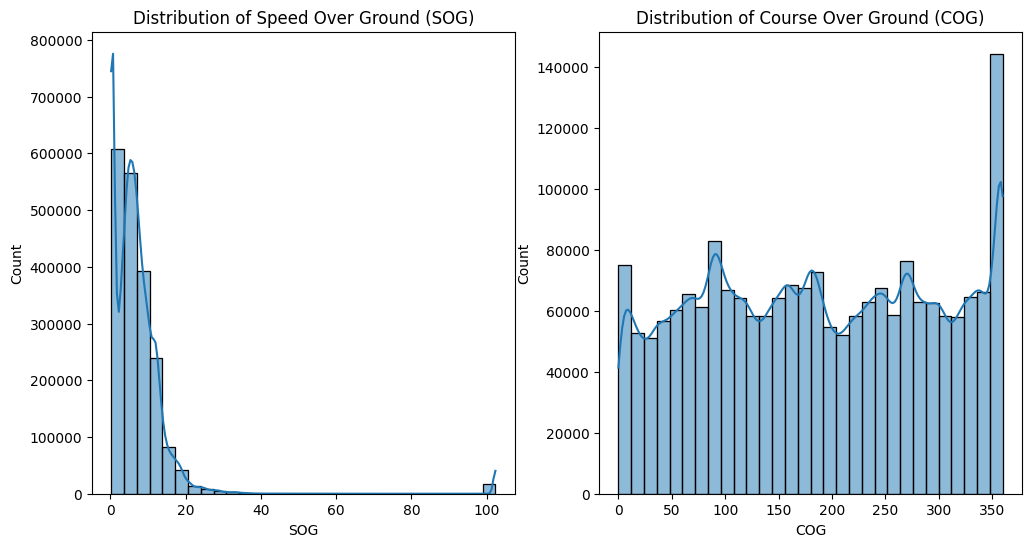

In [143]:
# Histograms for SOG and COG
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['SOG'], bins=30, kde=True)
plt.title('Distribution of Speed Over Ground (SOG)')

plt.subplot(1, 2, 2)
sns.histplot(df['COG'], bins=30, kde=True)
plt.title('Distribution of Course Over Ground (COG)')
plt.show()

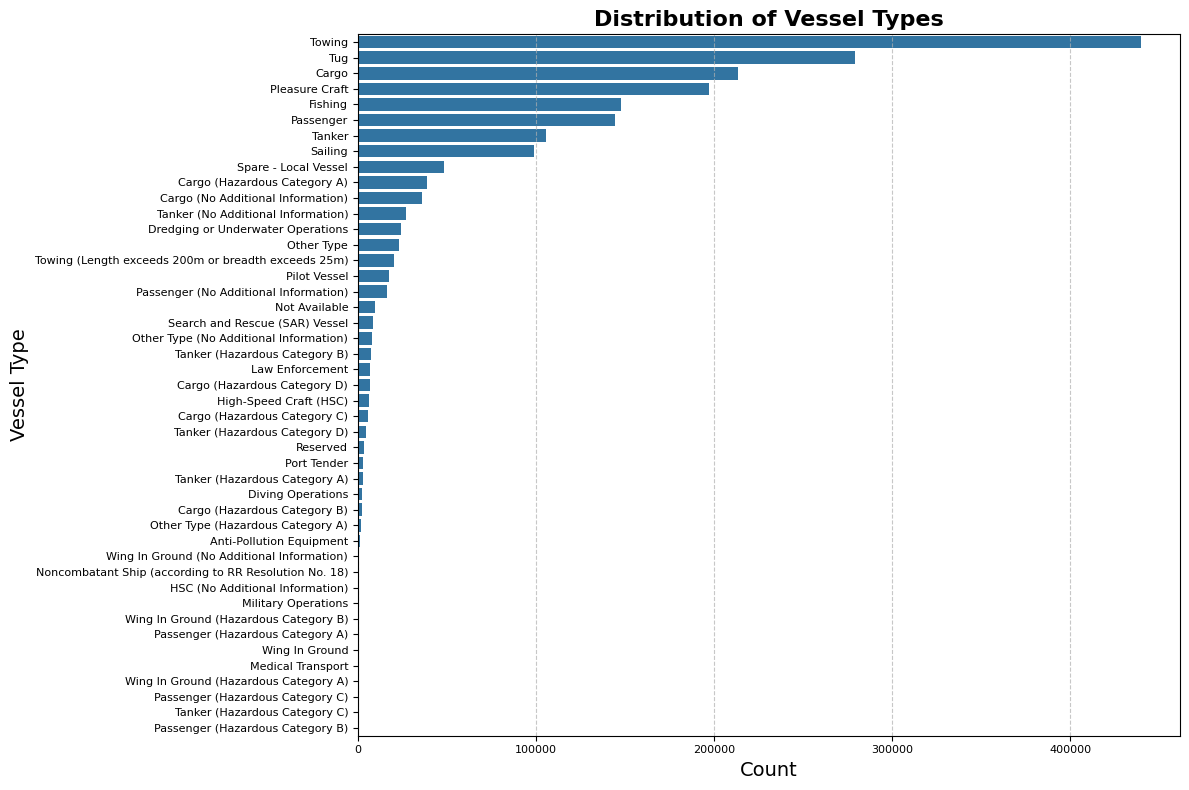

In [144]:
vessel_counts = df['VesselType'].value_counts()

plt.figure(figsize=(12, 8))  # Adjusting figure size
sns.barplot(y=vessel_counts.index, x=vessel_counts.values)  # Using a warmer color palette
plt.title('Distribution of Vessel Types', fontsize=16, fontweight='bold')  # Adding a title
plt.xlabel('Count', fontsize=14)  # Labeling the x-axis
plt.ylabel('Vessel Type', fontsize=14)  # Labeling the y-axis
plt.xticks(fontsize=8)  # Adjusting x-axis tick font size
plt.yticks(fontsize=8, rotation=0)  # Adjusting y-axis tick font size
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Adding gridlines for better readability
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [145]:
df['VesselType']

7             Tanker
8             Towing
13         Passenger
14            Towing
15         Passenger
             ...    
7296270        Cargo
7296271        Cargo
7296272        Cargo
7296273        Cargo
7296274        Cargo
Name: VesselType, Length: 1975442, dtype: object

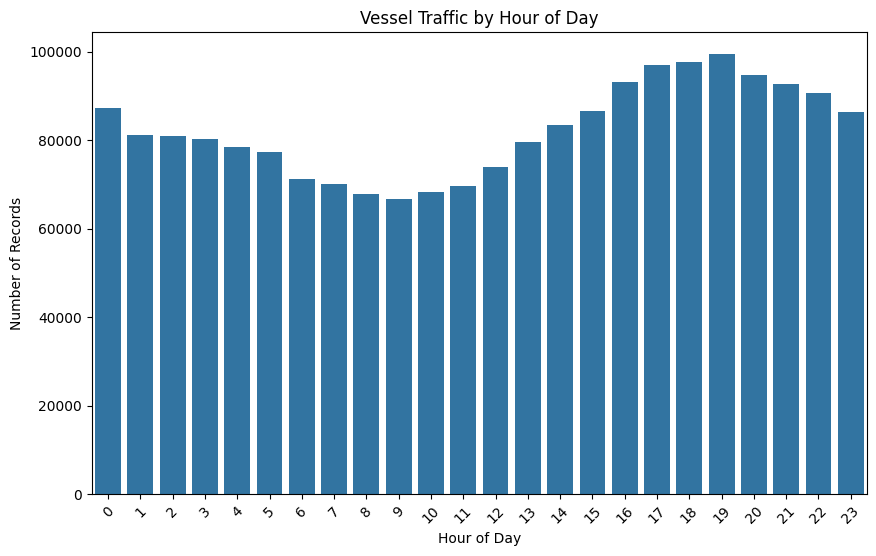

In [146]:
# Extract date and hour if not already done
df['Date'] = df['BaseDateTime'].dt.date
df['Hour'] = df['BaseDateTime'].dt.hour

# Plotting traffic by hour of day
plt.figure(figsize=(10, 6))
sns.countplot(x='Hour', data=df)
plt.title('Vessel Traffic by Hour of Day')
plt.ylabel('Number of Records')
plt.xlabel('Hour of Day')
plt.xticks(rotation=45)
plt.show()


In [147]:

# Define latitude and longitude bins
lat_bins = pd.cut(df['LAT'], bins=10)  # Adjust bins as needed
lon_bins = pd.cut(df['LON'], bins=10)

# Group by lat/lon bins and sample proportionally within each group
df_sampled = df.groupby([lat_bins, lon_bins]).apply(lambda x: x.sample(frac=0.01, random_state=42)).reset_index(drop=True)


/var/folders/23/m666xnxn3yb59qvbhl4ddhk80000gn/T/ipykernel_94242/4076722666.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sampled = df.groupby([lat_bins, lon_bins]).apply(lambda x: x.sample(frac=0.01, random_state=42)).reset_index(drop=True)


In [148]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19753 entries, 0 to 19752
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   MMSI          19753 non-null  int64         
 1   BaseDateTime  19753 non-null  datetime64[ns]
 2   LAT           19753 non-null  float64       
 3   LON           19753 non-null  float64       
 4   SOG           19753 non-null  float64       
 5   COG           19753 non-null  float64       
 6   VesselType    19609 non-null  object        
 7   Date          19753 non-null  object        
 8   Hour          19753 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1), object(2)
memory usage: 1.3+ MB


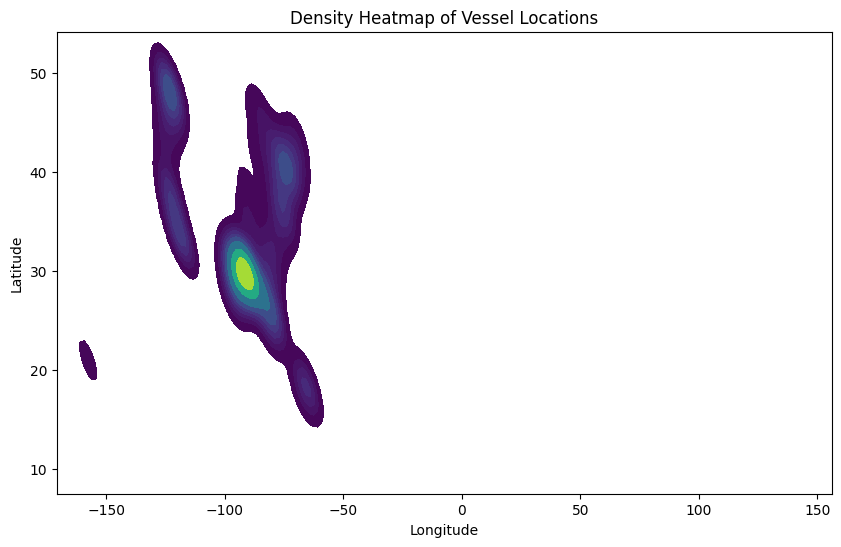

In [149]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x='LON', y='LAT', data=df_sampled, cmap="viridis", fill=True)
plt.title('Density Heatmap of Vessel Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


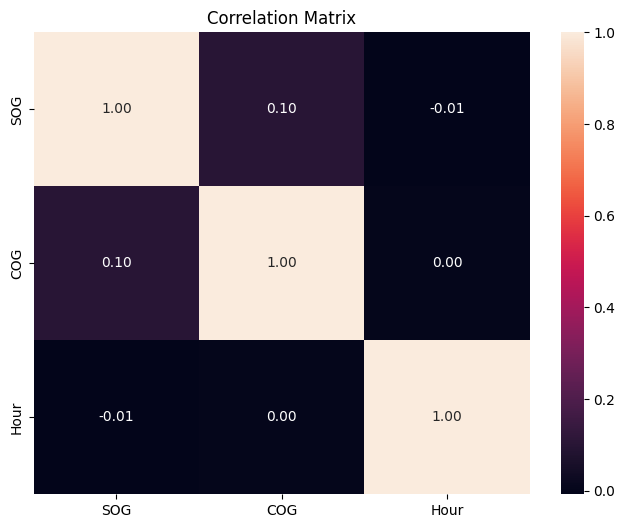

In [150]:
# Correlation matrix
corr = df[['SOG', 'COG', 'Hour']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [151]:
# Sort data by vessel and time
df = df.sort_values(by=['MMSI', 'BaseDateTime'])

# Calculate speed and course differences
df['SpeedDiff'] = df.groupby('MMSI')['SOG'].diff()  # Change in speed
df['CourseDiff'] = df.groupby('MMSI')['COG'].diff()  # Change in course

In [152]:
df_encoded = pd.get_dummies(df,columns=['VesselType'])

In [153]:
df_encoded.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Date,Hour,SpeedDiff,CourseDiff,...,VesselType_Tanker (Hazardous Category C),VesselType_Tanker (Hazardous Category D),VesselType_Tanker (No Additional Information),VesselType_Towing,VesselType_Towing (Length exceeds 200m or breadth exceeds 25m),VesselType_Tug,VesselType_Wing In Ground,VesselType_Wing In Ground (Hazardous Category A),VesselType_Wing In Ground (Hazardous Category B),VesselType_Wing In Ground (No Additional Information)
4919,3381234,2024-01-01 00:01:03,34.71526,-76.70942,0.6,98.5,2024-01-01,0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
13360,3381234,2024-01-01 00:03:03,34.71520,-76.70934,0.6,98.5,2024-01-01,0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
21737,3381234,2024-01-01 00:05:03,34.71520,-76.70929,0.6,0.0,2024-01-01,0,0.0,-98.5,...,False,False,False,False,False,False,False,False,False,False
30148,3381234,2024-01-01 00:06:59,34.71519,-76.70927,0.6,0.0,2024-01-01,0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
42725,3381234,2024-01-01 00:08:58,34.71518,-76.70927,0.4,38.1,2024-01-01,0,-0.2,38.1,...,False,False,False,False,False,False,False,False,False,False


In [154]:
df_encoded.isnull().sum()

MMSI                                                                   0
BaseDateTime                                                           0
LAT                                                                    0
LON                                                                    0
SOG                                                                    0
COG                                                                    0
Date                                                                   0
Hour                                                                   0
SpeedDiff                                                           9461
CourseDiff                                                          9461
VesselType_Anti-Pollution Equipment                                    0
VesselType_Cargo                                                       0
VesselType_Cargo (Hazardous Category A)                                0
VesselType_Cargo (Hazardous Category B)            

In [155]:
df_encoded['SpeedDiff'].fillna(0, inplace=True)
df_encoded['CourseDiff'].fillna(0, inplace=True)

/var/folders/23/m666xnxn3yb59qvbhl4ddhk80000gn/T/ipykernel_94242/736504799.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded['SpeedDiff'].fillna(0, inplace=True)
/var/folders/23/m666xnxn3yb59qvbhl4ddhk80000gn/T/ipykernel_94242/736504799.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

In [156]:
df_encoded.isnull().sum()

MMSI                                                                0
BaseDateTime                                                        0
LAT                                                                 0
LON                                                                 0
SOG                                                                 0
COG                                                                 0
Date                                                                0
Hour                                                                0
SpeedDiff                                                           0
CourseDiff                                                          0
VesselType_Anti-Pollution Equipment                                 0
VesselType_Cargo                                                    0
VesselType_Cargo (Hazardous Category A)                             0
VesselType_Cargo (Hazardous Category B)                             0
VesselType_Cargo (Ha

In [160]:
# Convert 'BaseDateTime' to datetime if not already done
df_encoded['BaseDateTime'] = pd.to_datetime(df_encoded['BaseDateTime'])

# Resample data every 5 minutes for each vessel
aggregation_interval = '5T'  # '5T' stands for 5 minutes

# Identify all one-hot encoded vessel type columns
vessel_type_columns = [col for col in df_encoded.columns if col.startswith('VesselType_')]

# Aggregation function dictionary with mean for each one-hot encoded column
aggregation_dict = {
    'LAT': 'mean',
    'LON': 'mean',
    'SOG': 'mean',
    'COG': 'mean',
    'SpeedDiff': 'mean',
    'CourseDiff': 'mean',
}

# Add the one-hot encoded columns to aggregation dictionary with mean
for col in vessel_type_columns:
    aggregation_dict[col] = 'mean'

# Convert 'BaseDateTime' to datetime if not already done
df_encoded['BaseDateTime'] = pd.to_datetime(df_encoded['BaseDateTime'])

# Group by MMSI (vessel identifier) and resample every 5 minutes
df_aggregated = df_encoded.set_index('BaseDateTime').groupby('MMSI').resample(aggregation_interval).agg(aggregation_dict).reset_index()

# Drop rows with NaN values, if any, after resampling
df_aggregated.dropna(inplace=True)

/var/folders/23/m666xnxn3yb59qvbhl4ddhk80000gn/T/ipykernel_94242/3568447714.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_aggregated = df_encoded.set_index('BaseDateTime').groupby('MMSI').resample(aggregation_interval).agg(aggregation_dict).reset_index()


In [161]:
df_aggregated.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,SpeedDiff,CourseDiff,VesselType_Anti-Pollution Equipment,VesselType_Cargo,...,VesselType_Tanker (Hazardous Category C),VesselType_Tanker (Hazardous Category D),VesselType_Tanker (No Additional Information),VesselType_Towing,VesselType_Towing (Length exceeds 200m or breadth exceeds 25m),VesselType_Tug,VesselType_Wing In Ground,VesselType_Wing In Ground (Hazardous Category A),VesselType_Wing In Ground (Hazardous Category B),VesselType_Wing In Ground (No Additional Information)
0,3381234,2024-01-01 00:00:00,34.715230,-76.709380,0.600000,98.5,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3381234,2024-01-01 00:05:00,34.715190,-76.709277,0.533333,12.7,-0.066667,-20.133333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3381234,2024-01-01 00:10:00,34.715200,-76.709345,0.400000,38.1,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3381234,2024-01-01 00:15:00,34.715205,-76.709360,0.600000,39.5,0.150000,1.400000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3381234,2024-01-01 00:20:00,34.715230,-76.709350,0.450000,145.1,-0.200000,76.050000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
# Set the sampling fraction; for example, 10% of the data
sampling_fraction = 0.1

# Apply random sampling to the aggregated data
df_sampled = df_aggregated.sample(frac=sampling_fraction, random_state=42)


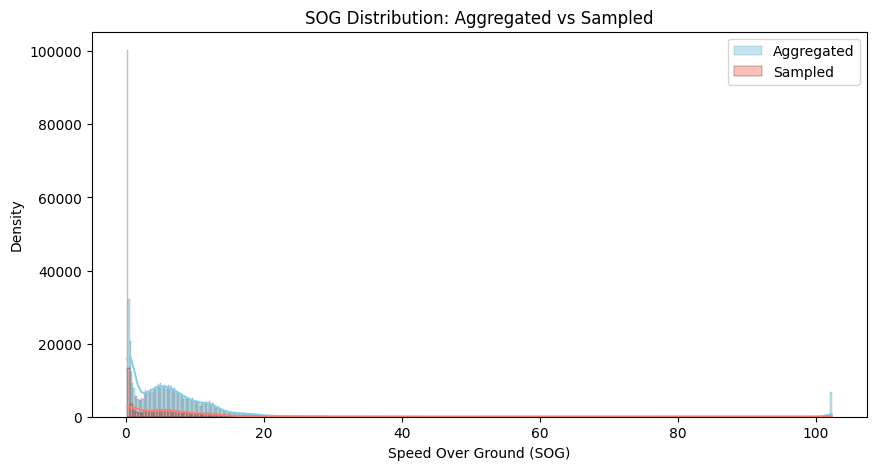

In [163]:
# Plot comparison of SOG distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_aggregated['SOG'], kde=True, color='skyblue', label='Aggregated')
sns.histplot(df_sampled['SOG'], kde=True, color='salmon', label='Sampled')
plt.legend()
plt.title("SOG Distribution: Aggregated vs Sampled")
plt.xlabel("Speed Over Ground (SOG)")
plt.ylabel("Density")
plt.show()

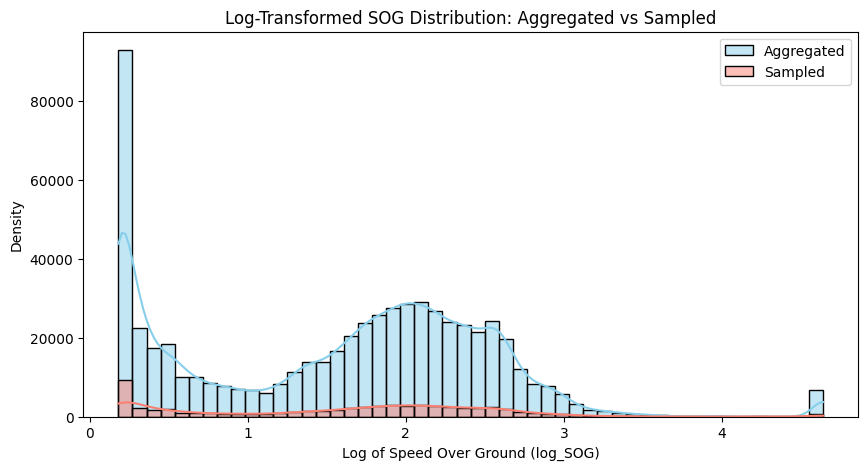

In [164]:
# Apply log transformation to SOG to spread out values
df_aggregated['log_SOG'] = np.log1p(df_aggregated['SOG'])  # log1p handles log(0) by adding 1
df_sampled['log_SOG'] = np.log1p(df_sampled['SOG'])

# Plot comparison of log-transformed SOG distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_aggregated['log_SOG'], kde=True, color='skyblue', label='Aggregated', bins=50)
sns.histplot(df_sampled['log_SOG'], kde=True, color='salmon', label='Sampled', bins=50)
plt.legend()
plt.title("Log-Transformed SOG Distribution: Aggregated vs Sampled")
plt.xlabel("Log of Speed Over Ground (log_SOG)")
plt.ylabel("Density")
plt.show()

Looking at the log-transformed distribution of SOG (Speed Over Ground), we can evaluate whether the sampled data is representative of the aggregated data.

1. Distribution Shape: The sampled data closely follows the shape of the aggregated data in many regions, particularly around the main density peaks. This indicates that the sampling method has retained the overall distribution pattern, which is a positive sign for representativeness.

2. Density Proportion: Although the distribution shape is similar, the density values are much lower in the sampled data compared to the aggregated data. This is expected since we have reduced the dataset size, so the counts are lower, but the overall trends still align.

3. Critical Points: There is a high-density peak around log_SOG close to 0 in the aggregated data, which is also reflected in the sampled data, though on a smaller scale. Other peaks around log_SOG values of approximately 1 to 2 are also captured in the sample.

In [165]:
# Perform the Kolmogorov-Smirnov test on the original and sampled SOG values
ks_stat, p_value = ks_2samp(df_aggregated['SOG'], df_sampled['SOG'])

print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

KS Statistic: 0.0023899806457242656
P-value: 0.9061399899975919


The results of the Kolmogorov-Smirnov (KS) test indicate the following:

KS Statistic is 0.0024 (approximately), which is very close to 0. This suggests that there is minimal difference between the cumulative distributions of the original and sampled data for the SOG (Speed Over Ground) variable.
P-value is 0.9061, which is significantly higher than the typical significance level of 0.05. This high p-value suggests that we do not have enough evidence to reject the null hypothesis that the two distributions are the same.

In [121]:
# Selecting features for anomaly detection
anomaly_features = df_sampled[['SOG', 'COG']]

# Initialize and train the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.01, random_state=42)  # Set contamination as per your tolerance level
df_sampled['anomaly'] = isolation_forest.fit_predict(anomaly_features)

# Interpret results: -1 indicates an anomaly, 1 indicates normal
df_sampled['anomaly'] = df_sampled['anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

# Checking the distribution of anomalies
print(df_sampled['anomaly'].value_counts())


anomaly
Normal     61473
Anomaly       11
Name: count, dtype: int64


In [166]:
df_sampled['Hour'] = df_sampled['BaseDateTime'].dt.hour
df_sampled['Minute'] = df_sampled['BaseDateTime'].dt.minute
df_sampled['Second'] = df_sampled['BaseDateTime'].dt.second

Mean Squared Error: 0.010835404447582162
Mean Absolute Error: 0.0826920227157029


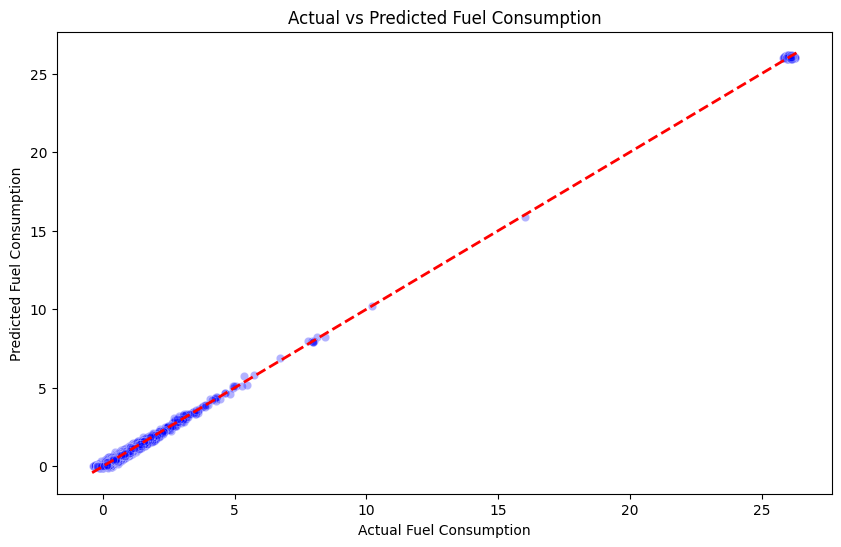

In [170]:

# Step 1: Feature Engineering
# Add squared speed as a feature to account for non-linear relationship with fuel consumption
df_sampled['SOG_squared'] = df_sampled['SOG'] ** 2

# Define features and target (synthetic fuel consumption)
features = ['LAT', 'LON', 'SOG', 'SOG_squared', 'COG', 'Hour', 'Minute', 'Second'] + vessel_type_columns

# Generate synthetic target for demonstration purposes
# Note: Replace this with actual fuel consumption data if available
np.random.seed(42)  # for reproducibility
df_sampled['fuel_consumption'] = 0.05 * df_sampled['SOG'] + 0.002 * df_sampled['SOG_squared'] + np.random.normal(0, 0.1, len(df_sampled))

# Define X and y
X = df_sampled[features]
y = df_sampled['fuel_consumption']

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Predict and evaluate the model
y_pred = rf_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Step 5: Plotting Results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Fuel Consumption')
plt.ylabel('Predicted Fuel Consumption')
plt.title('Actual vs Predicted Fuel Consumption')
plt.show()

The results in the plot indicate that our model is performing exceptionally well on the sampled dataset, with very low Mean Squared Error (MSE) and Mean Absolute Error (MAE). The points align closely with the red diagonal line, which represents a near perfect prediction, suggesting that the model’s predictions for fuel consumption are almost identical to the actual values.
Since we generated the fuel consumption variable synthetically using a mathematical function of the input features, the model could easily capture the relationship due to the lack of real-world noise and complexity. The synthetic target was directly dependent on SOG and SOG_squared, making it easier for the model to learn the pattern. The sampled data also may not represent the complexity of the full dataset. If the sampled data is relatively homogeneous, it could make predictions easier, especially for a powerful model like Random Forest that can capture intricate patterns in smaller datasets.
There is a risk that the model may be overfitting the data if the patterns are too predictable. Random Forests, being an ensemble of decision trees, can sometimes overfit if the data has easily separable patterns.


In [172]:
# Define custom scoring function for MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring=mse_scorer)

# Convert scores to positive and calculate mean and standard deviation
cv_scores = -cv_scores
print("Cross-Validation MSE Scores:", cv_scores)
print("Mean CV MSE:", np.mean(cv_scores))
print("Standard Deviation of CV MSE:", np.std(cv_scores))

Cross-Validation MSE Scores: [0.01375147 0.01100123 0.01100818 0.01101658 0.01097161]
Mean CV MSE: 0.011549813643623591
Standard Deviation of CV MSE: 0.0011009347715010853


In [173]:
importances = rf_model.feature_importances_
feature_names = X.columns

# Display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                                              Feature    Importance
3                                         SOG_squared  6.359330e-01
2                                                 SOG  3.629325e-01
4                                                 COG  2.370094e-04
1                                                 LON  2.346544e-04
0                                                 LAT  2.342968e-04
5                                                Hour  1.571706e-04
6                                              Minute  1.311104e-04
48                                     VesselType_Tug  1.490298e-05
46                                  VesselType_Towing  1.425807e-05
34                          VesselType_Pleasure Craft  1.370167e-05
28                               VesselType_Passenger  1.161035e-05
9                                    VesselType_Cargo  1.072715e-05
17                                 VesselType_Fishing  1.040686e-05
37                                 VesselType_Sa

SOG_squared and SOG features alone account for over 99% of the feature importance, indicating that the model is almost entirely dependent on speed-related features. This dominance suggests that the fuel consumption model is heavily influenced by vessel speed, which aligns with real-world expectations. However, such a strong dependence might also mean the model could struggle if there’s a slight shift in the relationship between speed and fuel consumption.
The minimal importance of VesselType suggests that it’s contributing little information under the current configuration. It might be since our synthetic definition of calculating fuel consumption doesn't take into account the vessel type features such as size, efficiency etc. 

In [175]:
# Add random noise to the target variable
noise = np.random.normal(0, 0.1, len(y_train))  # Adjust the standard deviation to control noise level
y_train_noisy = y_train + noise

# Retrain the model with noisy data
rf_model_noisy = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_noisy.fit(X_train, y_train_noisy)

# Predict and evaluate
y_pred_noisy = rf_model_noisy.predict(X_test)
print("MSE with Noisy Data:", mean_squared_error(y_test, y_pred_noisy))
print("MAE with Noisy Data:", mean_absolute_error(y_test, y_pred_noisy))

MSE with Noisy Data: 0.011775475990106848
MAE with Noisy Data: 0.08635487210777298


In [184]:
import folium
from folium.plugins import HeatMap

# Create a base map centered on a relevant area
m = folium.Map(location=[30, -90], zoom_start=6)

# Add heatmap of fuel consumption based on latitude and longitude
heat_data = [[row['LAT'], row['LON'], row['fuel_consumption']] for index, row in df_sampled.iterrows()]
HeatMap(heat_data).add_to(m)
m